# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


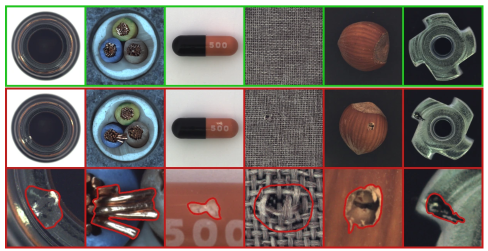

### SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

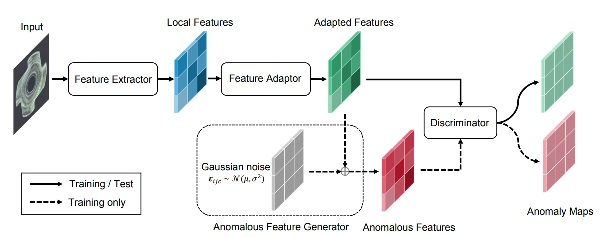


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

In [1]:
# !gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
# !unzip mvtec.zip

# 2.Prepare Environment

1.Install needed modules

In [2]:
# !pip install einops

2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [1]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
from tqdm import tqdm
import os
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt


#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [2]:
#######################################
# prepare dataset
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name='leather', is_train=True,
                 few_shot=16,resize=256):
        self.class_name = class_name
        self.is_train = is_train
        self.resize = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot = few_shot
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]


# 4.Load & Prepare Feature Extractor

In [3]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [4]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        scale_factor = target_size / current_size
        temp_feature = F.interpolate(features[i], scale_factor=scale_factor, mode='bilinear', align_corners=False)
        resized_feature.append(temp_feature)
        
        #############################################################

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- First, implement **the same Adaptor** in SimpleNet paper.
- Second, design your own version of Adaptor with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [5]:
# Implement the same Adaptor in SimpleNet
class Adaptor(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Adaptor, self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.linear = nn.Linear(self.in_channel, self.out_channel)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = rearrange(x, 'b c h w -> (b h w) c')
        x = self.linear(x)
        x = self.leaky_relu(x)
        
        return x

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [6]:
# Implement the same Discriminator in SimpleNet
class Discriminator(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator, self).__init__()
        self.in_channel = in_channel
        # mid_c = [32, 16] # 1024?
        self.body = nn.Sequential()
        mid_c = self.in_channel
        for i in range(2):
            in_c = in_channel if i == 0 else mid_c
            mid_c = int(mid_c // 1.5)
            self.body.add_module(
                name="Block%d" % (i + 1),
                module=nn.Sequential(
                    nn.Linear(in_c, mid_c), 
                    nn.BatchNorm1d(mid_c), 
                    nn.LeakyReLU(0.2)
                ),
            )
        self.tail = nn.Linear(mid_c, 1, bias=False)
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

# Implement your own Discriminator with fewer model parameters
class Discriminator_1(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator_1, self).__init__()
        self.in_channel = in_channel
        self.mid_channel = 512
        self.body = nn.Sequential(
            nn.Linear(self.in_channel, self.mid_channel), 
            nn.BatchNorm1d(self.mid_channel), 
            nn.LeakyReLU(0.2)
        )
        self.tail = nn.Linear(self.mid_channel, 1, bias=False)
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

class Discriminator_2(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator_2, self).__init__()
        self.in_channel = in_channel
        self.mid_channel = 1024
        self.body = nn.Sequential(
            nn.Linear(self.in_channel, self.mid_channel), 
            nn.BatchNorm1d(self.mid_channel), 
            nn.GELU()
        )
        self.tail = nn.Linear(self.mid_channel, 1, bias=False)
    
    def forward(self, x):
        x = self.body(x)
        x = self.tail(x)
        
        return x

# 7.Define Our Whole Model (SimpleNet)

In [7]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel, model_type=0):
        super(Simplenet,self).__init__()
        self.adaptor = Adaptor(in_channel,in_channel)
        if(model_type == 0):
            self.discriminator = Discriminator(in_channel)
        elif(model_type == 1):
            self.discriminator = Discriminator_1(in_channel)
        elif(model_type == 2):
            self.discriminator = Discriminator_2(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

# 8.Define The Training Process

In [8]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 # margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss += loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [9]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    result['features_orig'] = list()
    result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [10]:
def compute_roc_auc(y_label, scores):
    fpr, tpr, _ = roc_curve(y_label, scores)
    roc_auc = auc(fpr, tpr)
    # roc_auc = roc_auc_score(y_label, scores)
    
    return fpr, tpr, roc_auc

# 11.Define Other Utility Functions (if Needed)

In [11]:
def plot_roc_auc(fpr, tpr, roc_auc, class_name):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{class_name} ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [12]:
# Create datasets for both classes
dataset_train_metal = MVTecDataset(class_name="metal_nut", is_train=True, few_shot=196)
dataset_train_leather = MVTecDataset(class_name="leather", is_train=True, few_shot=196)
dataset_test_metal = MVTecDataset(class_name="metal_nut", is_train=False)
dataset_test_leather = MVTecDataset(class_name="leather", is_train=False)

metal_nut training dataset created, consists of 196 images
leather training dataset created, consists of 196 images
metal_nut testing dataset created, consists of 115 images
leather testing dataset created, consists of 124 images


In [13]:
# Training parameters
adaptor_lr = 1e-4
discriminator_lr = 2e-5
epochs = 20
batch_size = 16

# Define use_layers
use_layers = [2, 3]

In [14]:
# Create SimpleNet and optimizer for both classes
simplenet_metal_origin = Simplenet(in_channel=1536, model_type=0).cuda()
opt_adaptor_metal_origin = torch.optim.AdamW(simplenet_metal_origin.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_metal_origin = torch.optim.Adam(simplenet_metal_origin.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

simplenet_leather_origin = Simplenet(in_channel=1536, model_type=0).cuda()
opt_adaptor_leather_origin = torch.optim.AdamW(simplenet_leather_origin.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_leather_origin = torch.optim.Adam(simplenet_leather_origin.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

In [16]:
# Training
loss_metal_list = []
loss_leather_list = []
for epoch in tqdm(range(epochs)):
    loss_metal = train_one_epoch(encoder, simplenet_metal_origin, opt_adaptor_metal_origin, opt_discriminator_metal_origin, dataset_train_metal, use_layers, batch_size)
    loss_leather = train_one_epoch(encoder, simplenet_leather_origin, opt_adaptor_leather_origin, opt_discriminator_leather_origin, dataset_train_leather, use_layers, batch_size)
    print(f"Epoch {epoch + 1}")
    print(f"Metal loss: {loss_metal}")
    print(f"Leather loss: {loss_leather}\n")
    loss_metal_list.append(loss_metal)
    loss_leather_list.append(loss_leather)

  0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  5%|▌         | 1/20 [00:12<03:49, 12.07s/it]

Epoch 1
Metal loss: 4.0986175537109375
Leather loss: 5.020351886749268



 10%|█         | 2/20 [00:22<03:16, 10.90s/it]

Epoch 2
Metal loss: 0.09176258742809296
Leather loss: 0.2946893870830536



 15%|█▌        | 3/20 [00:32<02:58, 10.48s/it]

Epoch 3
Metal loss: 0.017192060127854347
Leather loss: 0.037306785583496094



 20%|██        | 4/20 [00:42<02:44, 10.29s/it]

Epoch 4
Metal loss: 0.009259361773729324
Leather loss: 0.013105696067214012



 25%|██▌       | 5/20 [00:52<02:32, 10.19s/it]

Epoch 5
Metal loss: 0.006027617957442999
Leather loss: 0.007436311338096857



 30%|███       | 6/20 [01:02<02:21, 10.13s/it]

Epoch 6
Metal loss: 0.004629603587090969
Leather loss: 0.0049949330277740955



 35%|███▌      | 7/20 [01:12<02:11, 10.10s/it]

Epoch 7
Metal loss: 0.0038252135273069143
Leather loss: 0.004618811421096325



 40%|████      | 8/20 [01:22<02:01, 10.09s/it]

Epoch 8
Metal loss: 0.002832397585734725
Leather loss: 0.003368424717336893



 45%|████▌     | 9/20 [01:32<01:50, 10.07s/it]

Epoch 9
Metal loss: 0.002348917303606868
Leather loss: 0.003322823438793421



 50%|█████     | 10/20 [01:42<01:40, 10.07s/it]

Epoch 10
Metal loss: 0.0023016445338726044
Leather loss: 0.002959880046546459



 55%|█████▌    | 11/20 [01:52<01:30, 10.06s/it]

Epoch 11
Metal loss: 0.0021491595543920994
Leather loss: 0.0022853428963571787



 60%|██████    | 12/20 [02:02<01:20, 10.06s/it]

Epoch 12
Metal loss: 0.0016700796550139785
Leather loss: 0.0022386901546269655



 65%|██████▌   | 13/20 [02:13<01:11, 10.25s/it]

Epoch 13
Metal loss: 0.0017457450740039349
Leather loss: 0.001963393297046423



 70%|███████   | 14/20 [02:23<01:02, 10.38s/it]

Epoch 14
Metal loss: 0.001440296764485538
Leather loss: 0.0017682493198662996



 75%|███████▌  | 15/20 [02:34<00:52, 10.51s/it]

Epoch 15
Metal loss: 0.0010172006441280246
Leather loss: 0.0015704245306551456



 80%|████████  | 16/20 [02:44<00:41, 10.40s/it]

Epoch 16
Metal loss: 0.001161344232968986
Leather loss: 0.001244212849996984



 85%|████████▌ | 17/20 [02:55<00:31, 10.41s/it]

Epoch 17
Metal loss: 0.0011059038806706667
Leather loss: 0.0013537383638322353



 90%|█████████ | 18/20 [03:05<00:20, 10.28s/it]

Epoch 18
Metal loss: 0.0009643530938774347
Leather loss: 0.0009654038585722446



 95%|█████████▌| 19/20 [03:15<00:10, 10.19s/it]

Epoch 19
Metal loss: 0.0008254895219579339
Leather loss: 0.0010780692100524902



100%|██████████| 20/20 [03:25<00:00, 10.27s/it]

Epoch 20
Metal loss: 0.0007768585928715765
Leather loss: 0.0009166959207504988



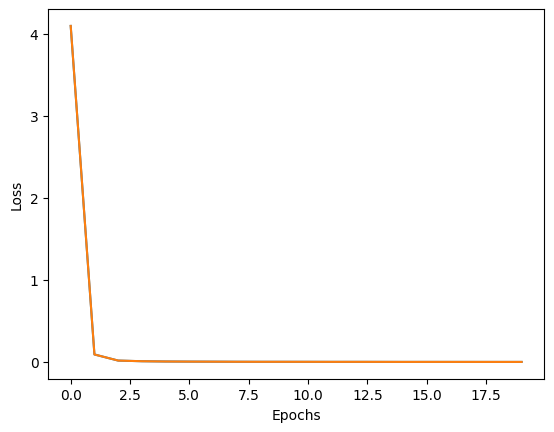

In [17]:
# Plot Loss Curve
loss_metal_array = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in loss_metal_list]
loss_leather_array = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in loss_leather_list]
plt.plot(range(epochs), loss_metal_array, label="Metal Training Loss")
plt.plot(range(epochs), loss_metal_array, label="Leather Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Calculate & Plot ROC curve

Metal-nut ROC-AUC score: 0.9481915933528836


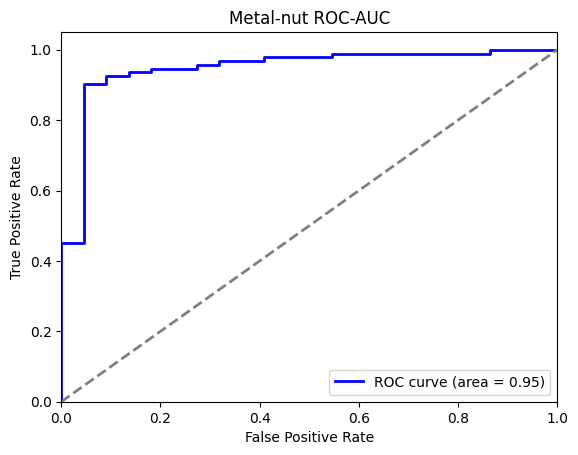

Leather ROC-AUC score: 1.0


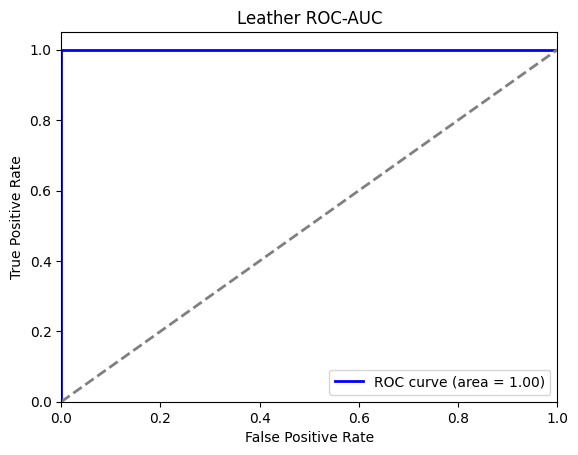

In [18]:
# Testing
result = test(encoder, simplenet_metal_origin, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Metal-nut")

result = test(encoder, simplenet_leather_origin, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Leather")

#### Simple Net with different discriminator

In [ ]:
simplenet_1 = Simplenet(in_channel=1536, model_type=1).cuda()
opt_adaptor_1 = torch.optim.AdamW(simplenet_1.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_1 = torch.optim.Adam(simplenet_1.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

simplenet_2 = Simplenet(in_channel=1536, model_type=2).cuda()
opt_adaptor_2 = torch.optim.AdamW(simplenet_2.adaptor.parameters(), lr=adaptor_lr)
opt_discriminator_2 = torch.optim.Adam(simplenet_2.discriminator.parameters(), lr=discriminator_lr, weight_decay=1e-5)

In [87]:
# Training
loss_list = []
for epoch in tqdm(range(epochs)):
    loss_1 = train_one_epoch(encoder, simplenet_1, opt_adaptor_1, opt_discriminator_1, dataset_train_metal, use_layers, batch_size)
    loss_2 = train_one_epoch(encoder, simplenet_1, opt_adaptor_1, opt_discriminator_1, dataset_train_leather, use_layers, batch_size)
    loss = (loss_1 + loss_2) / 2
    print(f"Epoch {epoch + 1} loss: {loss}\n")
    loss_list.append(loss)

  5%|▌         | 1/20 [00:08<02:38,  8.32s/it]

Epoch 1 loss: 7.752086162567139



 10%|█         | 2/20 [00:16<02:25,  8.10s/it]

Epoch 2 loss: 1.8276351690292358



 15%|█▌        | 3/20 [00:24<02:16,  8.03s/it]

Epoch 3 loss: 0.6192824244499207



 20%|██        | 4/20 [00:32<02:08,  8.01s/it]

Epoch 4 loss: 0.3216269314289093



 25%|██▌       | 5/20 [00:40<01:59,  8.00s/it]

Epoch 5 loss: 0.36060285568237305



 30%|███       | 6/20 [00:48<01:51,  7.99s/it]

Epoch 6 loss: 0.4363017976284027



 35%|███▌      | 7/20 [00:56<01:44,  8.00s/it]

Epoch 7 loss: 0.21831704676151276



 40%|████      | 8/20 [01:04<01:36,  8.00s/it]

Epoch 8 loss: 0.11969217658042908



 45%|████▌     | 9/20 [01:12<01:28,  8.01s/it]

Epoch 9 loss: 0.030096789821982384



 50%|█████     | 10/20 [01:20<01:20,  8.02s/it]

Epoch 10 loss: 0.022596100345253944



 55%|█████▌    | 11/20 [01:28<01:12,  8.02s/it]

Epoch 11 loss: 0.017004411667585373



 60%|██████    | 12/20 [01:36<01:04,  8.04s/it]

Epoch 12 loss: 0.014151019044220448



 65%|██████▌   | 13/20 [01:44<00:56,  8.06s/it]

Epoch 13 loss: 0.011984189972281456



 70%|███████   | 14/20 [01:52<00:48,  8.07s/it]

Epoch 14 loss: 0.010173387825489044



 75%|███████▌  | 15/20 [02:00<00:40,  8.09s/it]

Epoch 15 loss: 0.008865538984537125



 80%|████████  | 16/20 [02:08<00:32,  8.10s/it]

Epoch 16 loss: 0.007814574986696243



 85%|████████▌ | 17/20 [02:16<00:24,  8.11s/it]

Epoch 17 loss: 0.007106853183358908



 90%|█████████ | 18/20 [02:25<00:16,  8.12s/it]

Epoch 18 loss: 0.0062571559101343155



 95%|█████████▌| 19/20 [02:33<00:08,  8.12s/it]

Epoch 19 loss: 0.005440371111035347



100%|██████████| 20/20 [02:41<00:00,  8.07s/it]

Epoch 20 loss: 0.005271718371659517



In [94]:
# Training
loss_list = []
for epoch in tqdm(range(epochs)):
    loss_1 = train_one_epoch(encoder, simplenet_2, opt_adaptor_2, opt_discriminator_2, dataset_train_metal, use_layers, batch_size)
    loss_2 = train_one_epoch(encoder, simplenet_2, opt_adaptor_2, opt_discriminator_2, dataset_train_leather, use_layers, batch_size)
    loss = (loss_1 + loss_2) / 2
    print(f"Epoch {epoch + 1} loss: {loss}\n")
    loss_list.append(loss)

  5%|▌         | 1/20 [00:08<02:48,  8.88s/it]

Epoch 1 loss: 6.517777442932129



 10%|█         | 2/20 [00:17<02:36,  8.68s/it]

Epoch 2 loss: 0.5592525005340576



 15%|█▌        | 3/20 [00:25<02:26,  8.62s/it]

Epoch 3 loss: 0.13892565667629242



 20%|██        | 4/20 [00:34<02:17,  8.61s/it]

Epoch 4 loss: 0.07122068852186203



 25%|██▌       | 5/20 [00:43<02:08,  8.60s/it]

Epoch 5 loss: 0.04803597927093506



 30%|███       | 6/20 [00:51<02:00,  8.60s/it]

Epoch 6 loss: 0.028865531086921692



 35%|███▌      | 7/20 [01:00<01:51,  8.59s/it]

Epoch 7 loss: 0.020087765529751778



 40%|████      | 8/20 [01:08<01:43,  8.60s/it]

Epoch 8 loss: 0.016543174162507057



 45%|████▌     | 9/20 [01:17<01:34,  8.60s/it]

Epoch 9 loss: 0.014010550454258919



 50%|█████     | 10/20 [01:26<01:26,  8.60s/it]

Epoch 10 loss: 0.009726977907121181



 55%|█████▌    | 11/20 [01:34<01:17,  8.61s/it]

Epoch 11 loss: 0.0063089486211538315



 60%|██████    | 12/20 [01:43<01:08,  8.62s/it]

Epoch 12 loss: 0.0051160817965865135



 65%|██████▌   | 13/20 [01:52<01:00,  8.62s/it]

Epoch 13 loss: 0.004640845116227865



 70%|███████   | 14/20 [02:00<00:52,  8.70s/it]

Epoch 14 loss: 0.003839600831270218



 75%|███████▌  | 15/20 [02:09<00:43,  8.69s/it]

Epoch 15 loss: 0.003461781656369567



 80%|████████  | 16/20 [02:18<00:34,  8.68s/it]

Epoch 16 loss: 0.0032079718075692654



 85%|████████▌ | 17/20 [02:26<00:26,  8.68s/it]

Epoch 17 loss: 0.0026429614517837763



 90%|█████████ | 18/20 [02:35<00:17,  8.68s/it]

Epoch 18 loss: 0.0027910456992685795



 95%|█████████▌| 19/20 [02:44<00:08,  8.69s/it]

Epoch 19 loss: 0.0023211848456412554



100%|██████████| 20/20 [02:52<00:00,  8.65s/it]

Epoch 20 loss: 0.0021227109245955944



Metal-nut ROC-AUC score: 0.6686217008797655


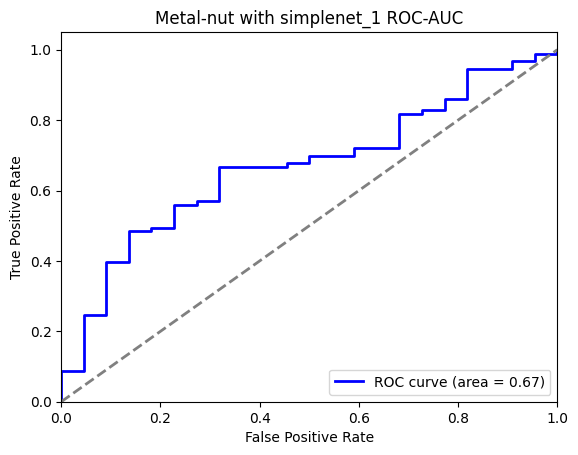

Leather ROC-AUC score: 0.6905570652173912


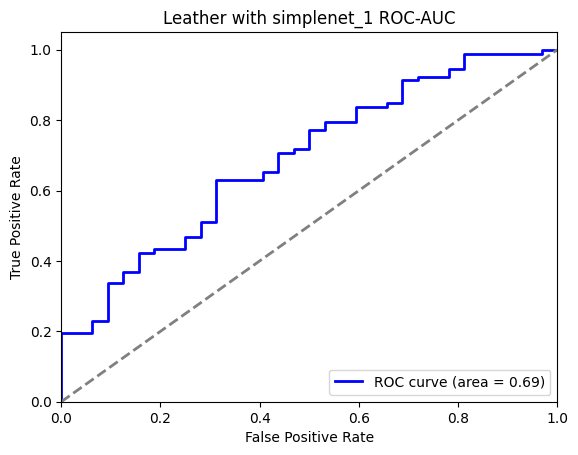

Metal-nut ROC-AUC score: 0.9848484848484849


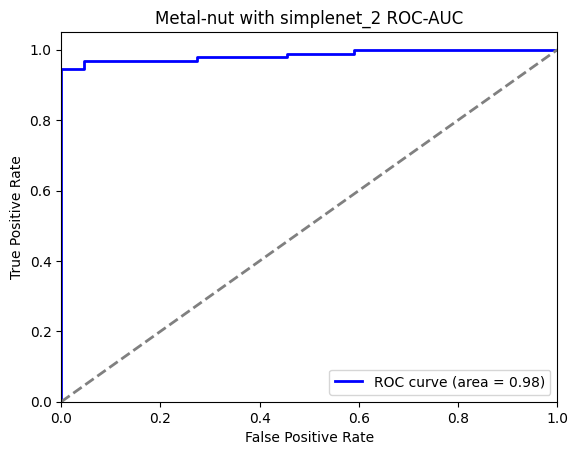

Leather ROC-AUC score: 0.9996603260869565


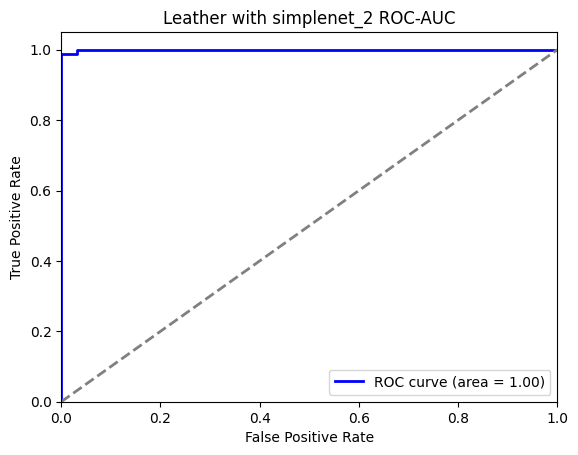

In [95]:
# Testing
result = test(encoder, simplenet_1, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Metal-nut with simplenet_1")

result = test(encoder, simplenet_1, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Leather with simplenet_1")

result = test(encoder, simplenet_2, dataset_test_metal, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Metal-nut ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Metal-nut with simplenet_2")

result = test(encoder, simplenet_2, dataset_test_leather, use_layers, batch_size=16)
fpr, tpr, roc_auc = compute_roc_auc(result['total_gt_image'], result['total_scores_image'])
print("Leather ROC-AUC score:", roc_auc)
plot_roc_auc(fpr, tpr, roc_auc, "Leather with simplenet_2")

# 15.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Adaptor/Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


In [ ]:
# Use the following code to measure your model parameters
num_params = sum(p.numel() for p in model.parameters())

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?